In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
import fbprophet
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

/Users/thientrangbui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
import warnings
warnings.filterwarnings("ignore")

**Train and Test data information**

* **store**: a unique Id for each store

* **DayOfWeek**: which day in a week **from 1 to 7**

* **Sales**: the turnover for any given day (this is what we are predicting)

* **Customers**: the number of customers on a given day

* **Open**: an indicator for whether the store was open: **0 = closed, 1 = open**

* **Promo**: indicates whether a store is running a promo on that day

* **StateHoliday**:  indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. **a = public holiday, b = Easter holiday, c = Christmas, 0 = None**

* **SchoolHoliday**: indicates if the (Store, Date) was affected by the closure of public schools

In [3]:
#read data : train.csv
train = pd.read_csv("/Users/thientrangbui/Dropbox/Kaggle competion/rossmann-store-sales/data rossmann-store-sales/train.csv",parse_dates = True, low_memory = False, index_col="Date")
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
#read data : test.csv
# it's less than the train data a colunm named by "Sales" which we want to predict for 6 next weeks
test = pd.read_csv("/Users/thientrangbui/Dropbox/Kaggle competion/rossmann-store-sales/data rossmann-store-sales/test.csv",parse_dates = True, low_memory = False, index_col="Date")
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [56]:
#index
print("given days in the train set: ", train.index) #from 01/01/2013 to 31/07/2015
print("given days in the test set: ", test.index) #from 01/08/2015 to 17/09/2015 means 6 weeks

given days in the train set:  DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)
given days in the test set:  DatetimeIndex(['2015-09-17', '2015-09-17', '2015-09-17', '2015-09-17',
               '2015-09-17', '2015-09-17', '2015-09-17', '2015-09-17',
               '2015-09-17', '2015-09-17',
               ...
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01',
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01',
               '2015-08-01', '2015-08-01'],
              dtype='datetime64[ns]', name='Date', length=41088, freq=None)


**More information about stores**

* **StoreType**: differentiates between 4 different store models: a, b, c, d

* **Assortment**: describes an assortment level: a = basic, b = extra, c = extended

* **CompetitionDistance**: distance in meters to the nearest competitor store

* **CopetitionOpenSinceMonth**: gives the approximate month of the time the nearest competitor was opened

* **CompetitionOpenSinceYear**: gives the approximate year of the time the nearest competitor was opened

* **Promo2**: is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* **Promo2SinceWeek**: describes the calendar week when the store started participating in Promo2

* **Promo2SinceYear**: describes the calendar year when the store started participating in Promo2

* **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [4]:
#read data: store.csv, which includes supplemental information about the stores
store = pd.read_csv("/Users/thientrangbui/Dropbox/Kaggle competion/rossmann-store-sales/data rossmann-store-sales/store.csv",low_memory = False)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


**Exploratory Data Analysis**

First, we need to clean data.

In [58]:
train.isnull().sum() #well, have no any NA's in the train set

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [13]:
train.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1
2013-01-01,1115,2,0,0,0,0,a,1


Now we concentrate in the feature **Sales**, let's take a look at its empirical culmilative distribution function.

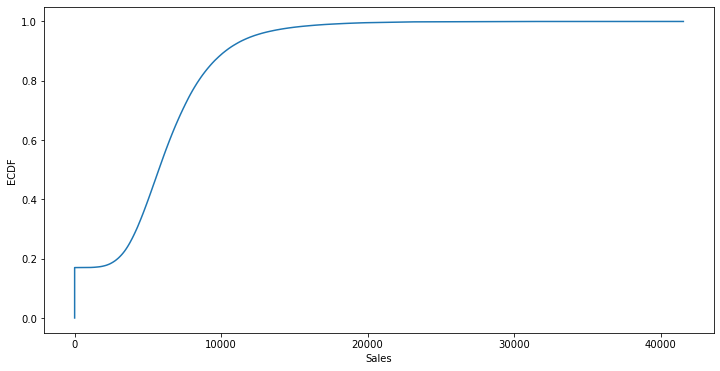

In [14]:
plt.figure(figsize = (12, 6))

cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Sales'); plt.ylabel('ECDF');

**Comments**: It's so strange there cause there exist almost 20% data having the zero amount of sales. So what about the zero sales, is it due to the stores closed. Let's see the two following cases:

* First case: Zero sale + Open = 0, we should remove these data cause they make biased forecasts.
* Second case: zero sale + Open = 1, it's strange when there exists opening stores but there have no sales on working days. It maybe causes the manifestation. ^.^

In [21]:
#first case
Sale0Close0 = train[(train.Sales == 0) & (train.Open == 0)]
Sale0Close0.shape

(172817, 8)

In [25]:
print("there're", len(Sale0Close0),"closed stores. It is", round((len(Sale0Close0)/len(train))*100),"% of the total amount of observations")

there're 172817 closed stores. It is 17 % of the total amount of observations


To avoid the bias forecasts, we will drop these values. Now we consider the open stores with no sales.

In [26]:
Sale0Open1 = train[(train.Sales == 0) & (train.Open == 1)]
Sale0Open1.shape

(54, 8)

It's so strange when there exists open stores with no sales on working days. We will only consider data including open stores and non-zeros sales.

In [5]:
train = train[(train.Sales != 0) & (train.Open != 0)]
print("In total: ", train.shape)

In total:  (844338, 8)


Now, let's see store's NA's:

In [28]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [29]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [30]:
#CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


As we see having no any particular patterns observed, so we decide to replace NA's competitionDistance by its medium values.

In [6]:
store["CompetitionDistance"].fillna(store['CompetitionDistance'].median(), inplace = True)

Now, we deal with **Promo2SinceWeek**, **PromoInterval** and **Promo2SinceYear**. These features relate directly to the feature **Promo2**, a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating. So let's see that do exist the story partucupating with these feature different with NA values.


In [37]:
#Promo2SinceWeek
temp1 = store[pd.isnull(store.Promo2SinceWeek)]
temp1[temp1.Promo2 != 0].shape

(0, 10)

In [38]:
#Promo2SinceYear
temp2 = store[pd.isnull(store.Promo2SinceYear)]
temp2[temp2.Promo2 != 0].shape

(0, 10)

In [39]:
#PromoInterval
temp3 = store[pd.isnull(store.PromoInterval)]
temp3[temp3.Promo2 != 0].shape

(0, 10)

Thus, it proves that all NA's values of the features: **Promo2SinceWeek**, **PromoInterval** and **Promo2SinceYear** causing that the stores do not participate in the continuing and consecutive promotion. So we replace the lack values of these feature by zeros. The same properties with the two features **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**

In [7]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [8]:
train['Date'] = pd.to_datetime(train.index)
train['MonthYear'] = pd.to_datetime(train.index).to_period('M')
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [23]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,Year,Month,Day,WeekOfYear,MonthYear
Date,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015-07-31,2015,7,31,31,2015-07
2015-07-31,2,5,6064,625,1,1,0,1,2015-07-31,2015,7,31,31,2015-07
2015-07-31,3,5,8314,821,1,1,0,1,2015-07-31,2015,7,31,31,2015-07
2015-07-31,4,5,13995,1498,1,1,0,1,2015-07-31,2015,7,31,31,2015-07
2015-07-31,5,5,4822,559,1,1,0,1,2015-07-31,2015,7,31,31,2015-07


Now, we join the train data set and store's infomation data.

In [9]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,MonthYear,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015-07-31,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015-07-30,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015-07-29,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015-07-28,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015-07-27,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [25]:
train_store.shape

(844338, 23)

**Data Exploration**

**1) Firtsly, we consider the Sales and Custommers changing over time on the train set**

In [10]:
#group by MonthYear to get the average sale over time Month - Year and precent change
average_sales_MonthYear = train.groupby('MonthYear')['Sales'].mean()
average_scustommers_MonthYear = train.groupby('MonthYear')['Customers'].mean()
pct_change_sales_MonthYear = train.groupby("MonthYear")['Sales'].sum().pct_change()

In [29]:
average_sales_MonthYear

MonthYear
2013-01    6240.506045
2013-02    6428.838730
2013-03    7213.092718
2013-04    6579.791664
2013-05    7077.028245
2013-06    6467.745839
2013-07    6923.613645
2013-08    6596.367019
2013-09    6363.615547
2013-10    6473.347016
2013-11    6904.509503
2013-12    8613.455299
2014-01    6540.313756
2014-02    6678.536710
2014-03    6654.709671
2014-04    7227.587658
2014-05    6948.119518
2014-06    7251.213362
2014-07    6893.938590
2014-08    6714.305191
2014-09    6758.808923
2014-10    6757.598370
2014-11    7539.603854
2014-12    8603.805210
2015-01    6913.177694
2015-02    6660.519241
2015-03    7071.483992
2015-04    7349.110170
2015-05    7308.779203
2015-06    7295.618795
2015-07    7033.344905
Freq: M, Name: Sales, dtype: float64

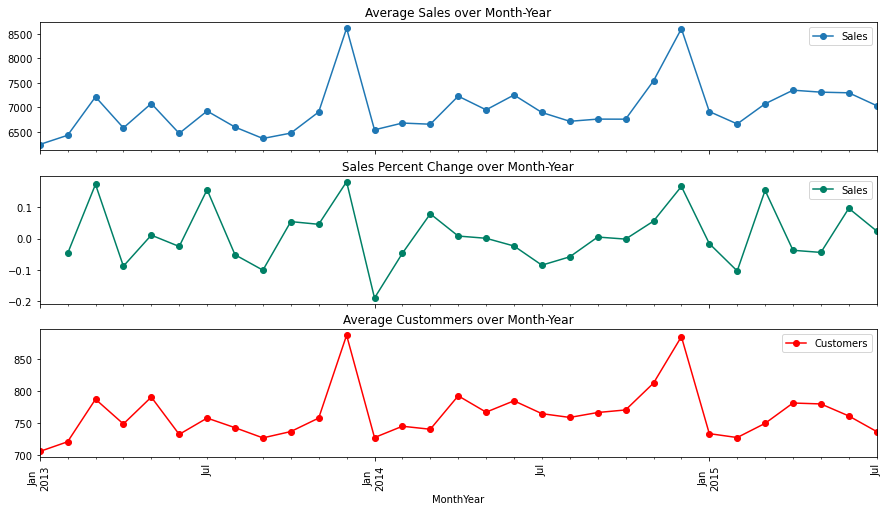

In [38]:
#plot 2 figures: one of the average sales over time and another of the percent change of sales
#over time
fig, (axis1,axis2,axis3) = plt.subplots(3,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales_MonthYear.plot(legend=True,ax=axis1,marker='o',title="Average Sales over Month-Year")
ax1.set_xticks(range(len(average_sales_MonthYear)))
ax1.set_xticklabels(average_sales_MonthYear.index, rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales_MonthYear.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change over Month-Year")

#plot average custommers over time
ax3 = average_scustommers_MonthYear.plot(legend=True,ax=axis3,marker='o',rot=90,colormap='autumn',title="Average Custommers over Month-Year")

**Comments:** 

We see that the higgest average sales and custommers in the Chirtmast is the common trend, so logically the percent change of sales is high in this period also. 

Text(0.5, 1.0, 'Customers boxplot')

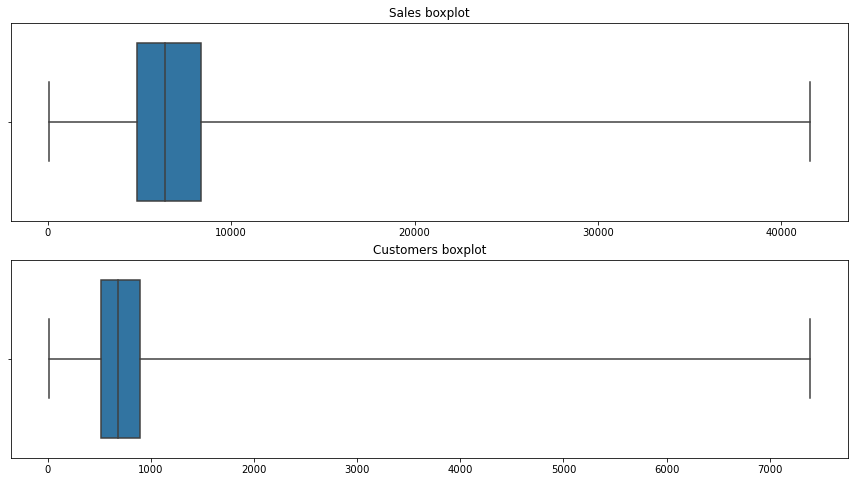

In [46]:
fig, (axis1, axis2) = plt.subplots(2,1,figsize = (15,8))

ax1 = sns.boxplot([train["Sales"]], whis=np.inf, ax=axis1)
ax1.set_title('Sales boxplot')

ax2 = sns.boxplot([train["Customers"]], whis=np.inf, ax=axis2)
ax2.set_title('Customers boxplot')

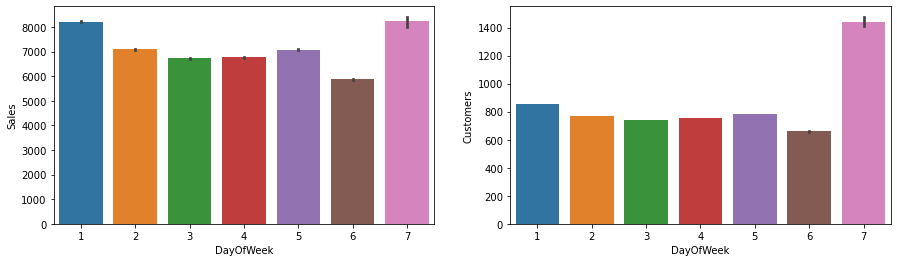

In [47]:
# DayOfWeek
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=train, order=[1,2,3,4,5,6,7], ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, order=[1,2,3,4,5,6,7], ax=axis2)

**Comments:**

In [48]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,Year,...,MonthYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015-07-31,2015,...,2015-07,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015-07-30,2015,...,2015-07,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015-07-29,2015,...,2015-07,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015-07-28,2015,...,2015-07,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015-07-27,2015,...,2015-07,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Text(0.5, 1.0, 'Customers')

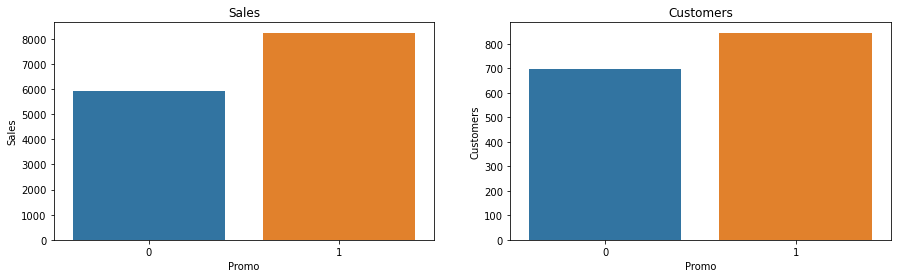

In [49]:
#Promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

ax1=sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
ax1.set_title("Sales")

ax2=sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)
ax2.set_title("Customers")

Here, we aim to consider the relationship between Sales, Customers with Promo and StoreType. 

In [50]:
train_store.groupby("StoreType")["Sales","Customers"].sum()

<ipython-input-50-f10433c8fecf>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_store.groupby("StoreType")["Sales","Customers"].sum()


,Sales,Customers
StoreType,,
a,3165334859,363541431
b,159231395,31465616
c,783221426,92129705
d,1765392943,156904995


**Comments:** Clearly stores of type A and StoreType D go on the second place in both Sales and Customers. Then, we see deeply them over time.

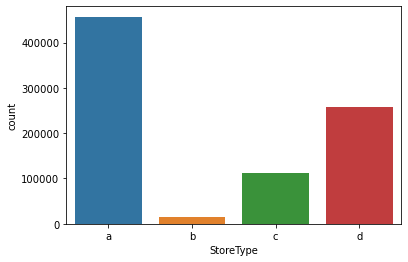

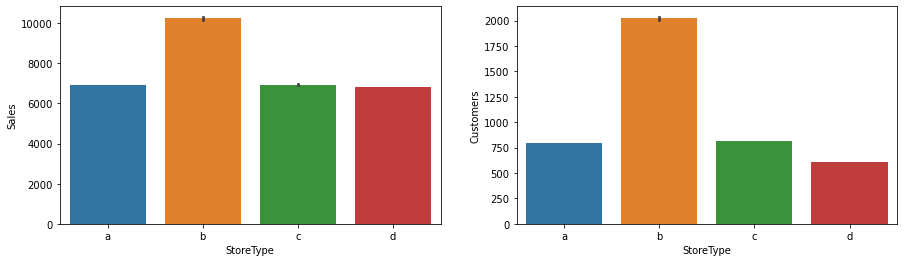

In [17]:
#Storetype
sns.countplot(x='StoreType', data=train_store, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=train_store, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=train_store, order=['a','b','c', 'd'], ax=axis2)

**Comments:**

* Number of stores type a is largest, over 400k stores, while number of stores type b is the least. 

* Although the number of stores type b is the least, they obtain the biggest sale. And the quantity of customers in these stores is also largest. 

* The sales of stores type a, c and d are quite same. And the customers in the stores d are less than the another stores a and c. 


/Users/thientrangbui/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


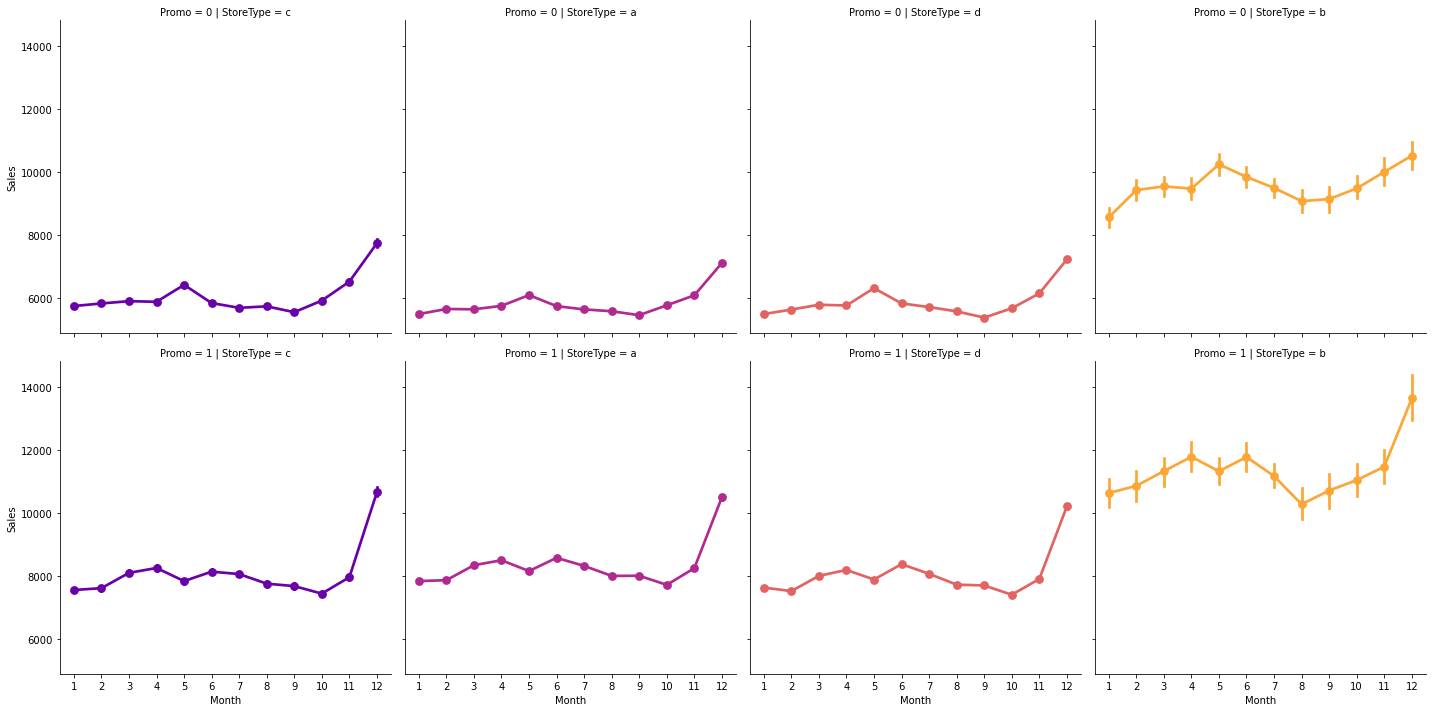

In [52]:
#Promo and StoreType of Sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = "summer") 

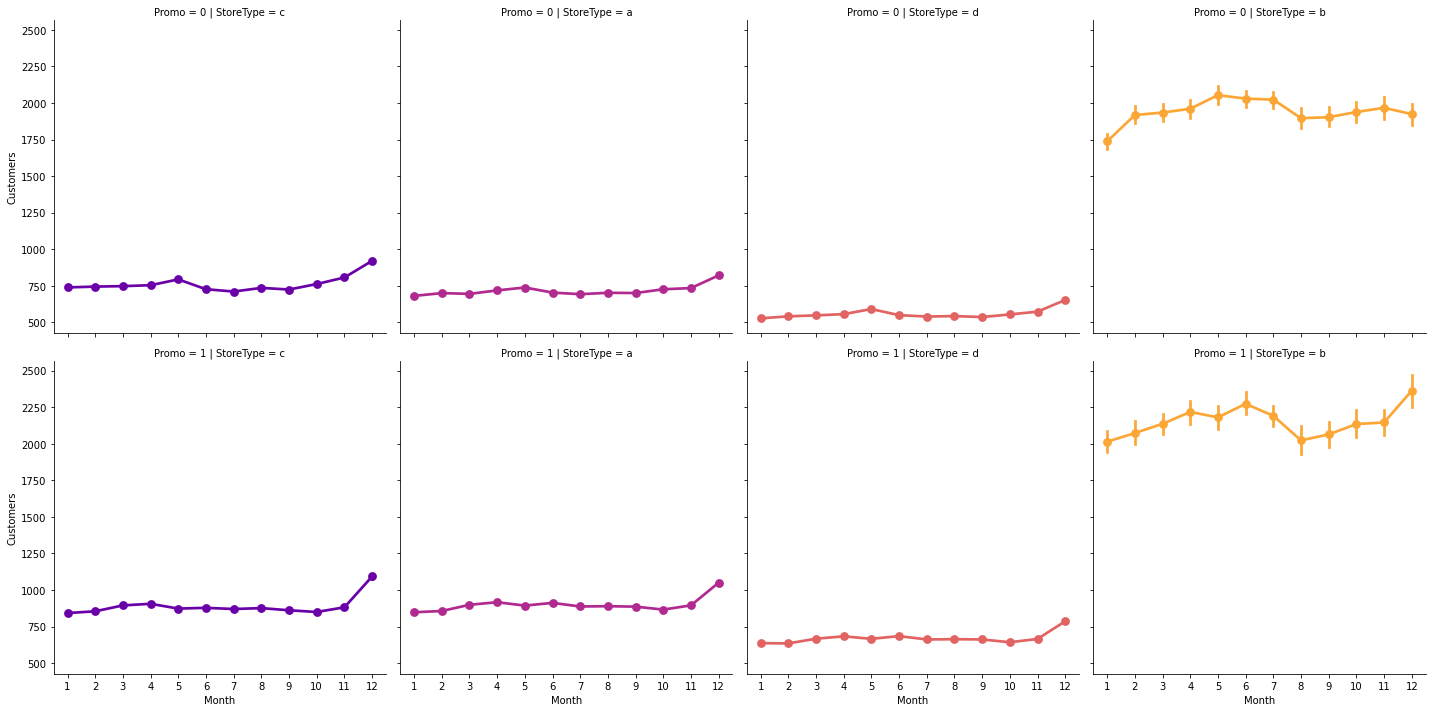

In [55]:
#Promo and StoreType of Customers
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = "summer") 

**Comments:** 

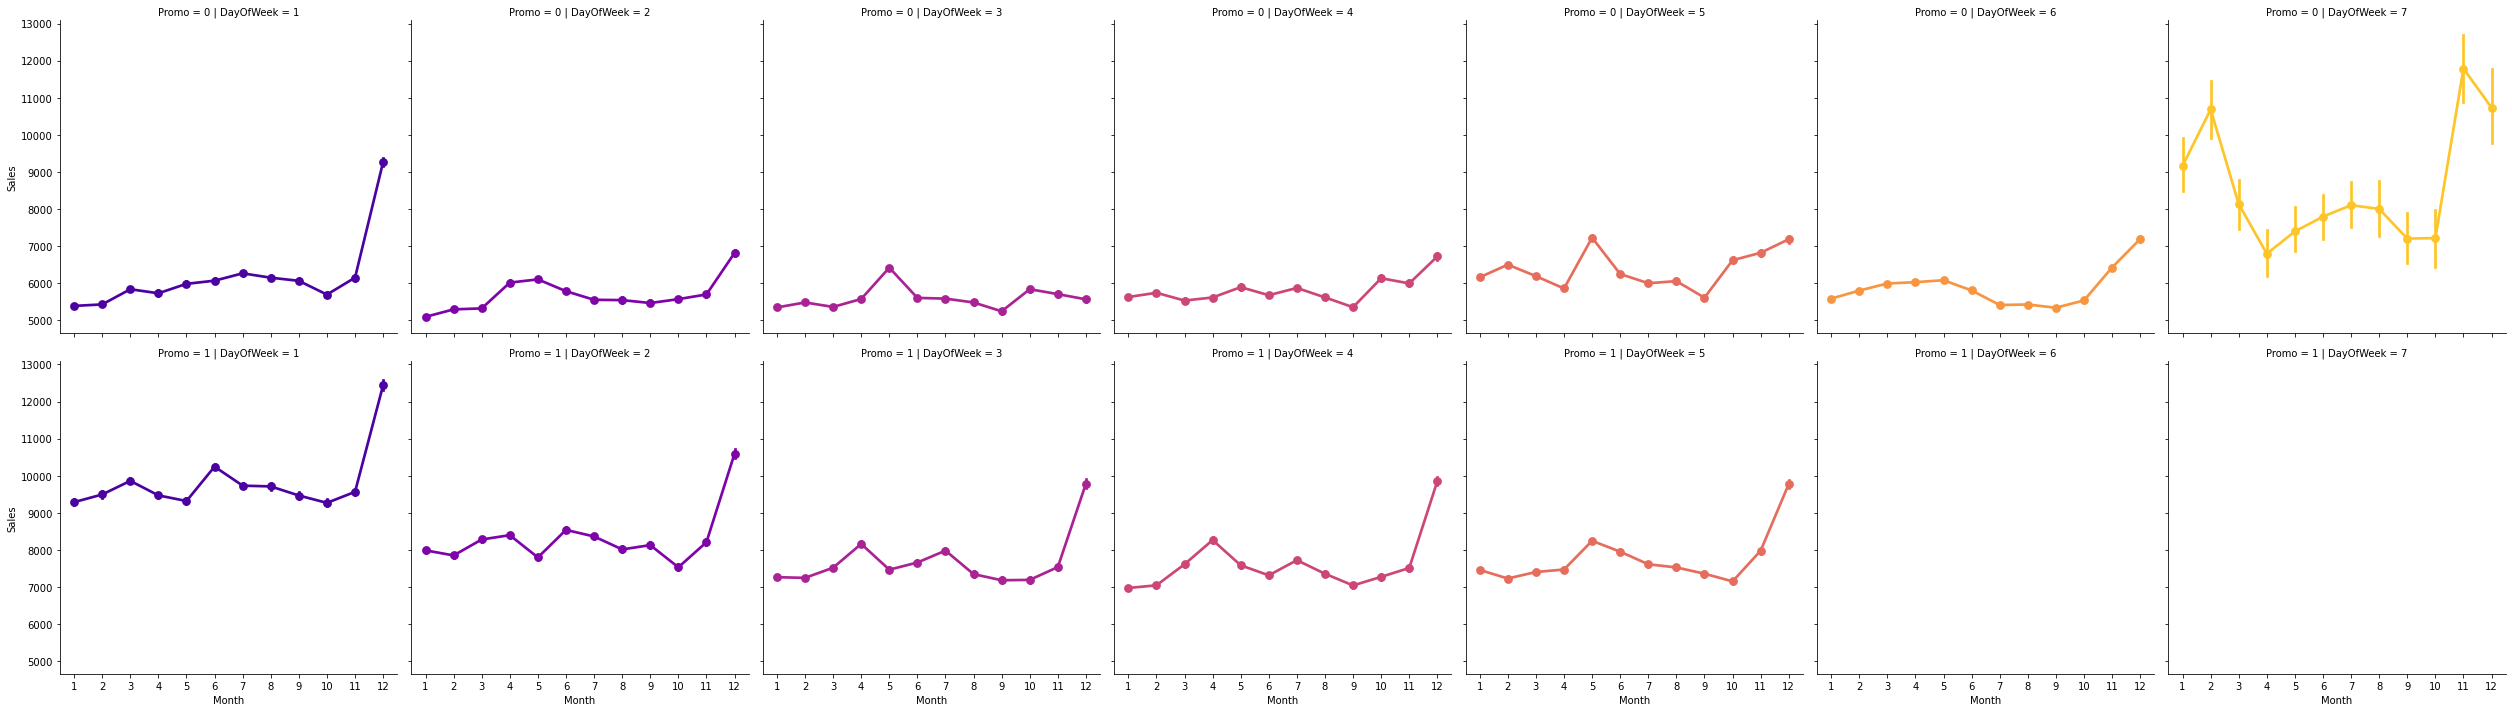

In [15]:
#promo with DayOfWeek of Sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'DayOfWeek',
               row = 'Promo', # per promo in the store in rows
               color = "summer") 

**Comments:** 
* At stores not running a promo, they close on weekends, but still open on weekend if without running a promo. 
* The highest sales at stores without runing a promo concentrate on Sunday.
* The same trend in sales is the amount of sales always being very high in the Chirtmast season.
* A reason explaining for stores running a promo, they do not open on weekend that might because they sales quite much on days of week. The sale amount at store running a promo is always higher than at stores without running a promo.
* At stores running a promo, the highest sale is on beginng of a week, Monday.

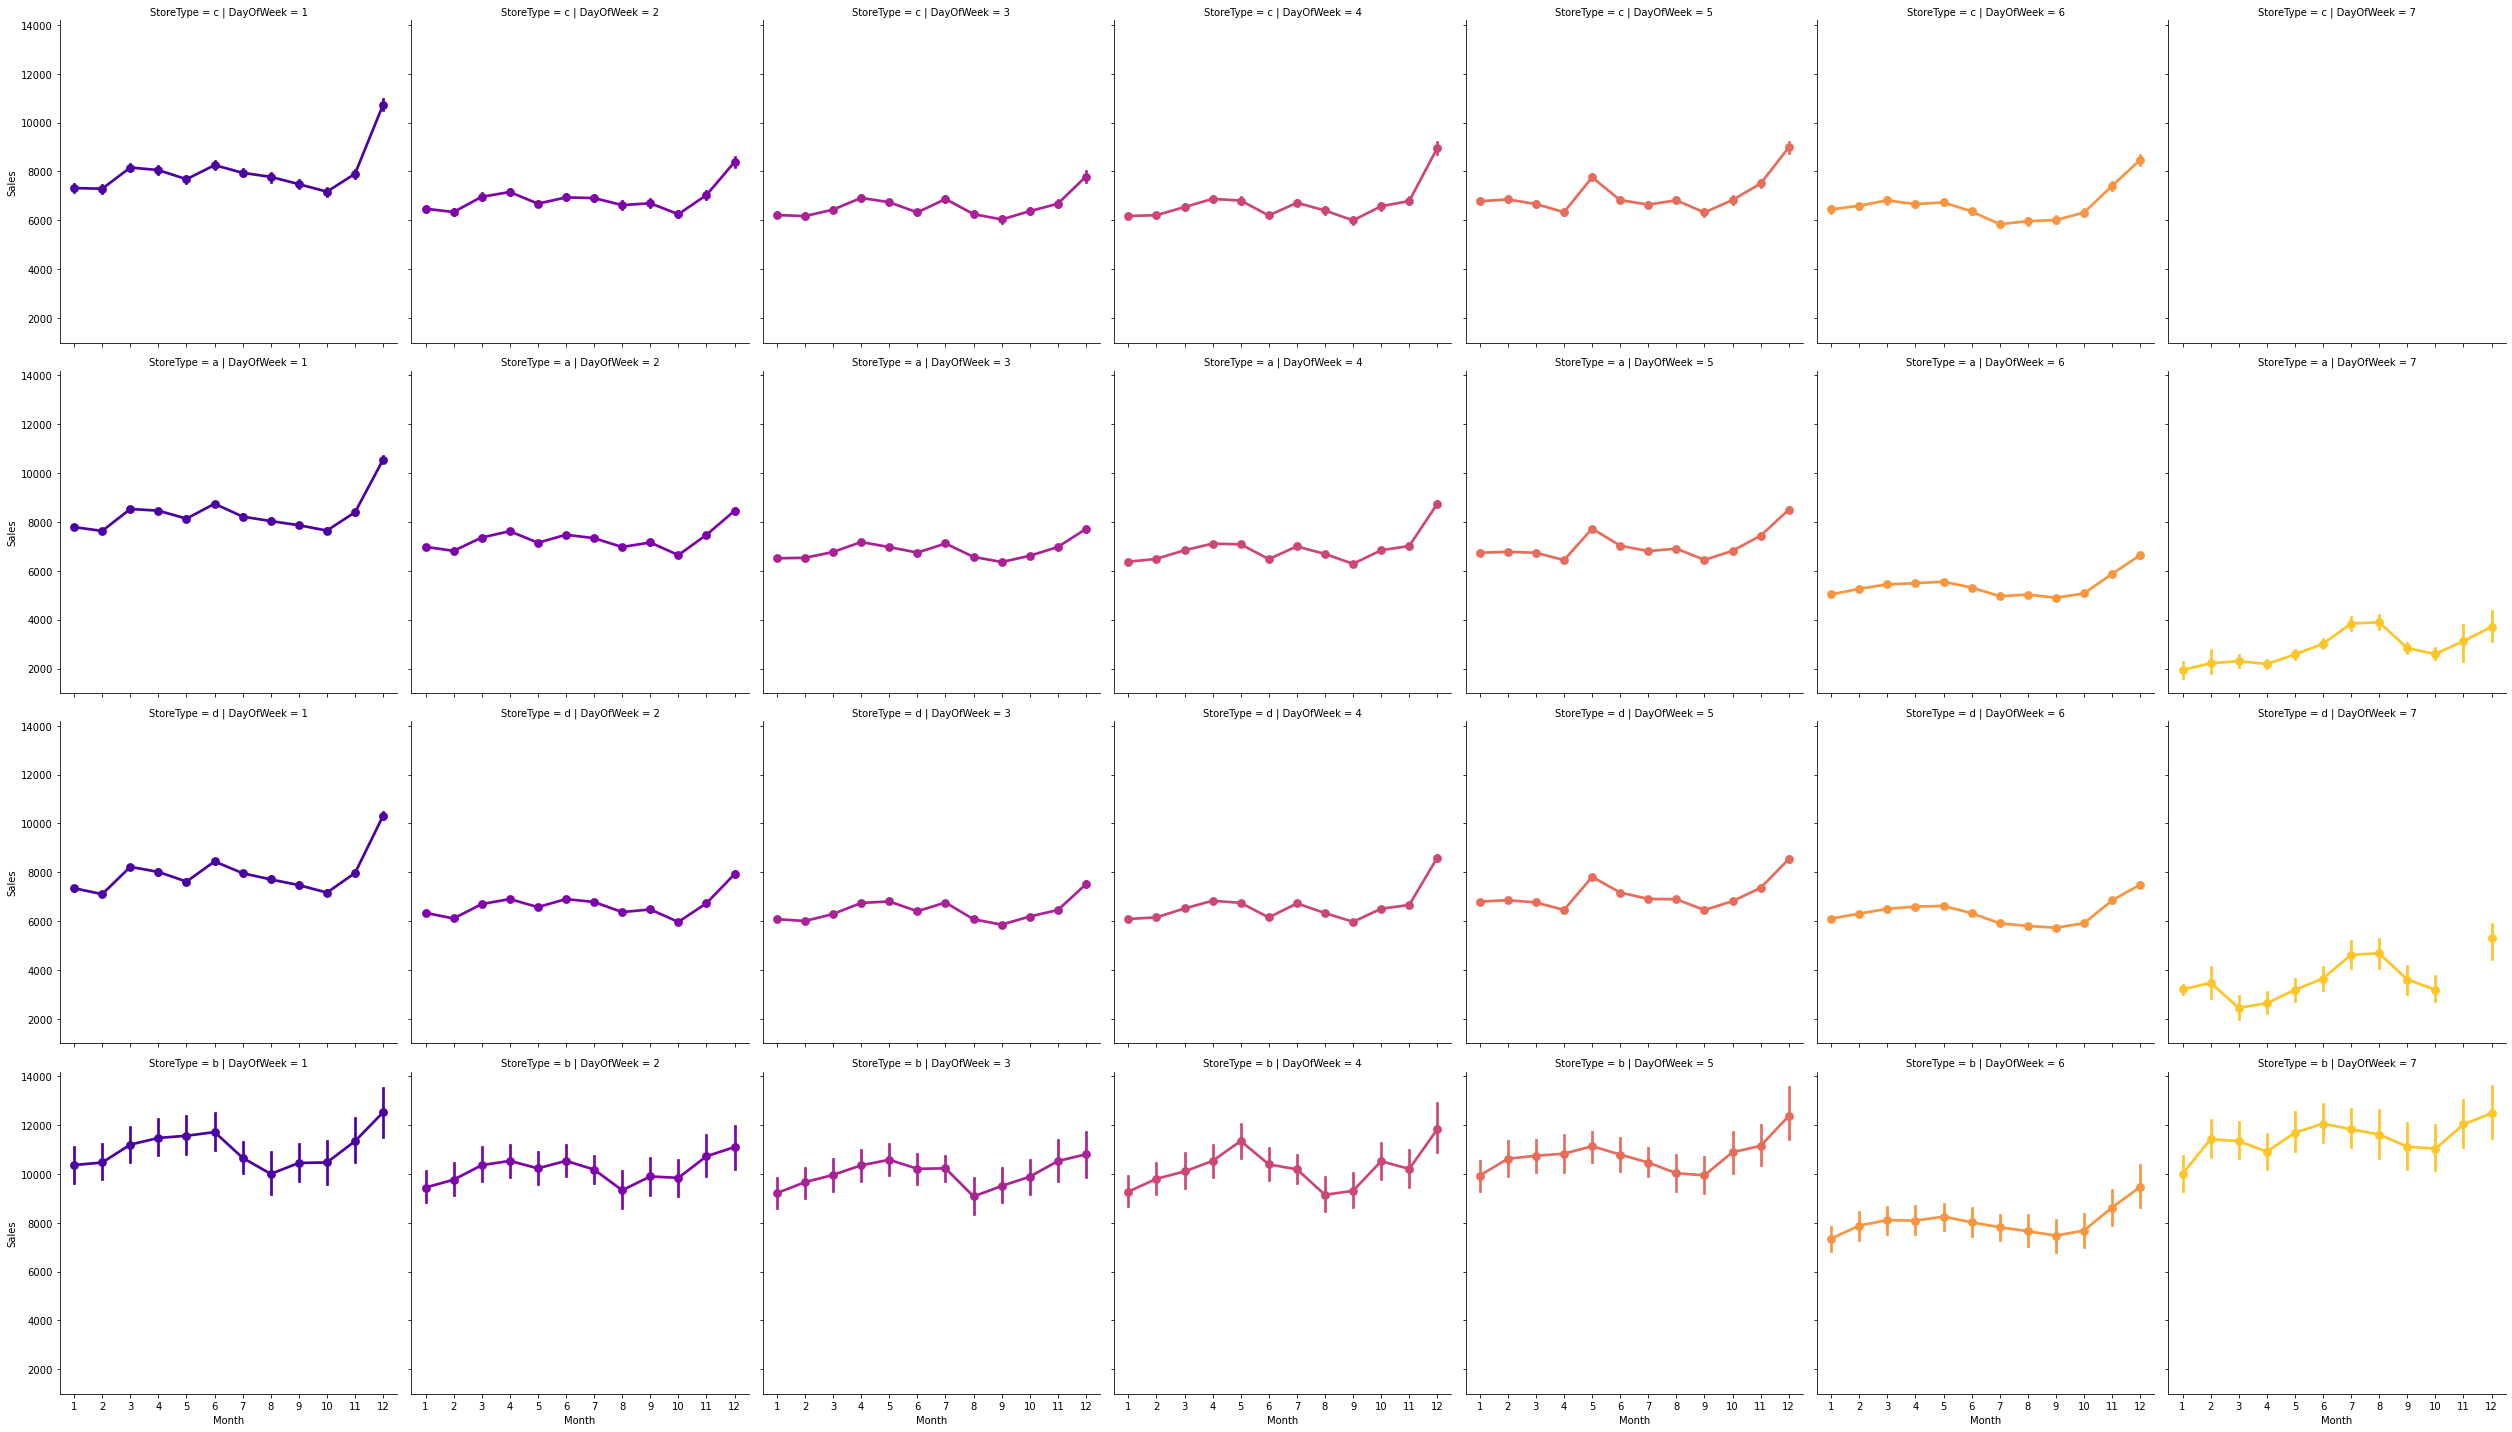

In [16]:
#TypeSale with DayOfWeek
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'DayOfWeek',
               row = 'StoreType', # per promo in the store in rows
               color = "summer") 

**Comments:**
* At store having type c, they do not open on the weekends. At Stores type c, they do not open on every Sartuday of November.
* Stores type b have the highest sales in the group of a, b, c, d. The sale amount of these stores seens the highest on everyday in the group.
* The common trend of the four types of store is to sale best on Monday.
* The sale amount on Sunday of stores type a and d looks very less. 
* And as usual, the stores sale very well in the Chirtmast season.

In [18]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,MonthYear,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015-07-31,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015-07-30,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015-07-29,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015-07-28,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015-07-27,2015-07,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [27]:
train_store.shape

(844338, 23)

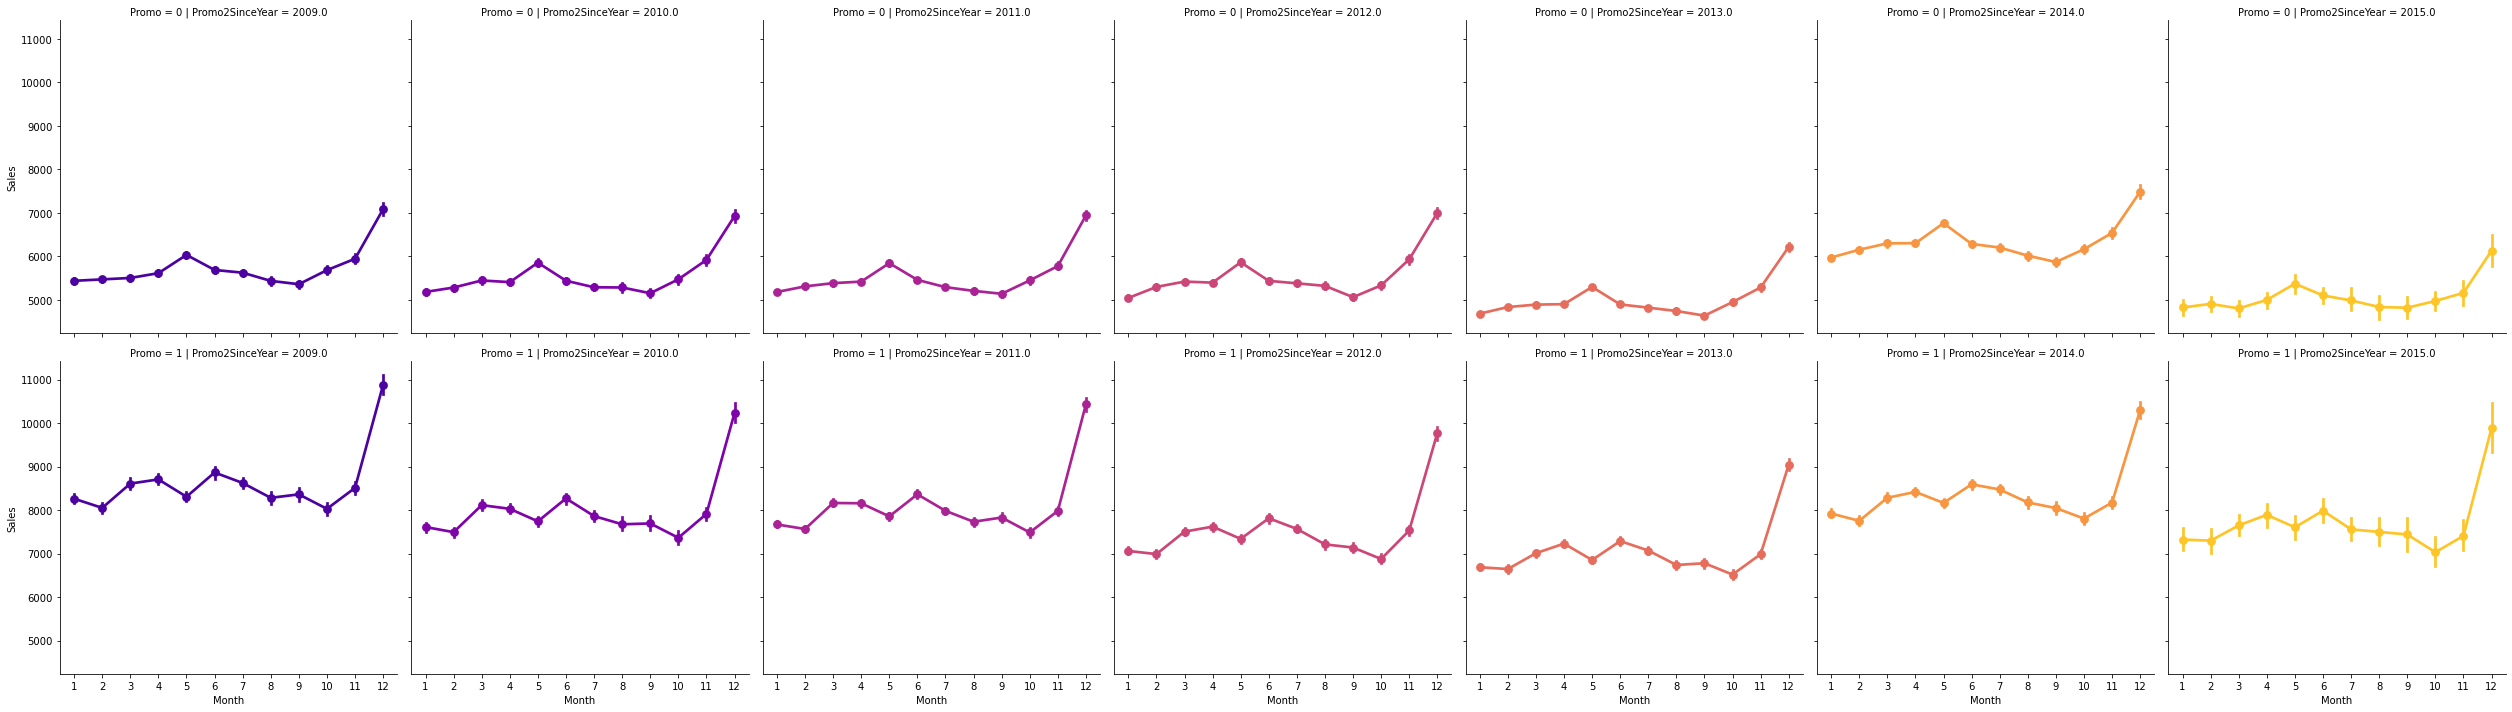

In [28]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo2SinceYear', # per store type in cols
               palette = 'plasma',
               hue = 'Promo2SinceYear',
               row = 'Promo', # per promo in the store in rows
               color = "summer") 

In [30]:
# StateHoliday
train_store.StateHoliday.unique()
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None

array(['0', 'a', 'b', 'c'], dtype=object)

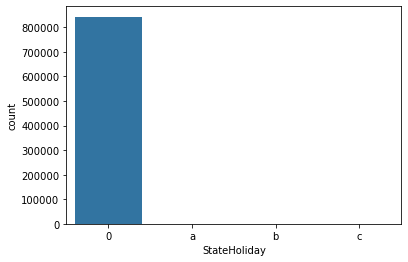

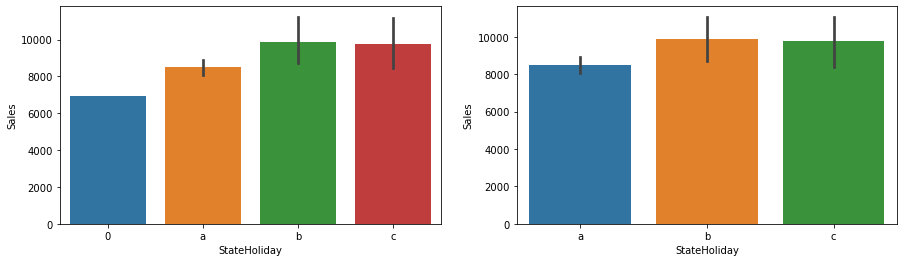

In [31]:
sns.countplot(x="StateHoliday", data= train_store)

fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.barplot(x='StateHoliday', y='Sales', data=train_store, ax=axis1)

temp = (train_store["StateHoliday"] != "0") & (train_store["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train_store[temp], ax=axis2)

**Comments:** 

* The Chrismas and Easter holidays are the best periods a year to sale and get big profit.

* Generally, even the number of days belongting to the state holidays are much less than the working days, the profit from state holidays is more than working days.  

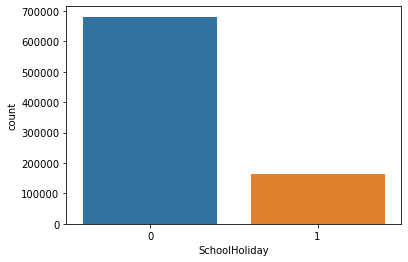

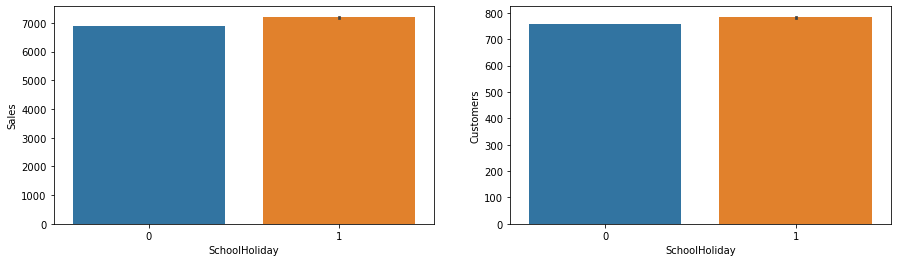

In [32]:
# SchoolHoliday
sns.countplot(x='SchoolHoliday', data=train_store)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train_store, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train_store, ax=axis2)

**Comments:** 

* In School holidays, stores can sale better although the number of these holidays is much less than working days. 

* Logically, the quantity of custommers in the school holidays is more than the working day too.

In [16]:
list(train_store.columns)

['Store',
 'DayOfWeek',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Date',
 'MonthYear',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

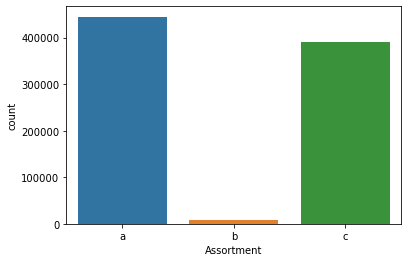

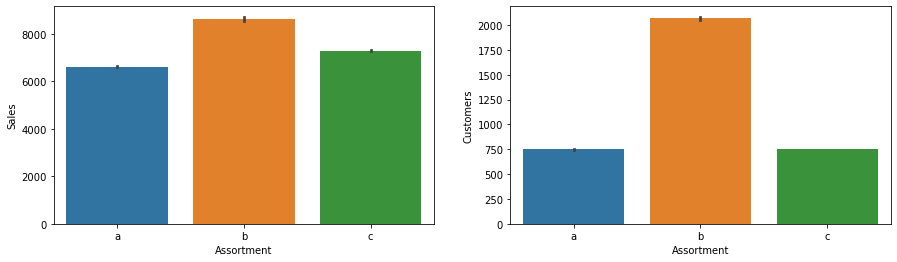

In [19]:
#assortment
#describes an assortment level: a = basic, b = extra, c = extended
sns.countplot(x='Assortment', data=train_store,order=['a','b','c'] )

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,4))
sns.barplot(x='Assortment', y='Sales', data=train_store, ax=axis1,order=['a','b','c'])
sns.barplot(x='Assortment', y='Customers', data=train_store, ax=axis2,order=['a','b','c'])

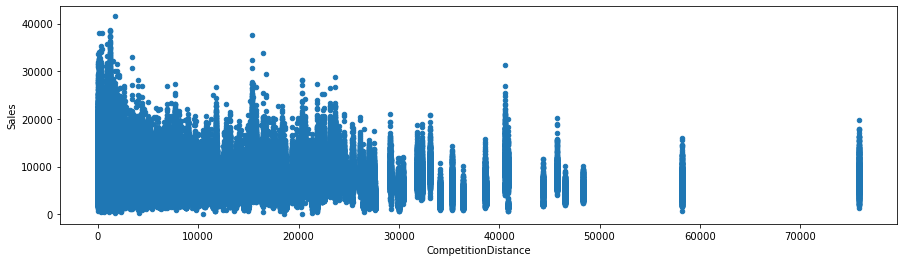

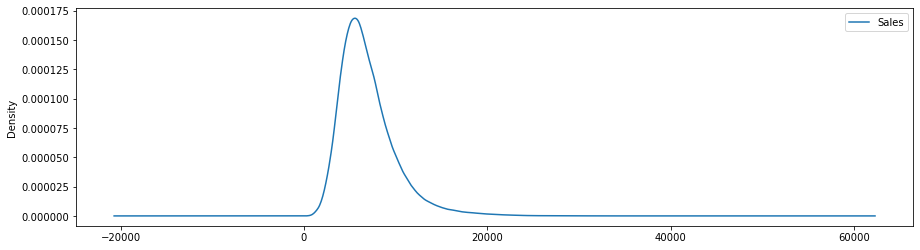

In [20]:
#CompetitionDistance with sales
train_store.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4))
train_store.plot(kind='kde',x='CompetitionDistance',y='Sales',figsize=(15,4))

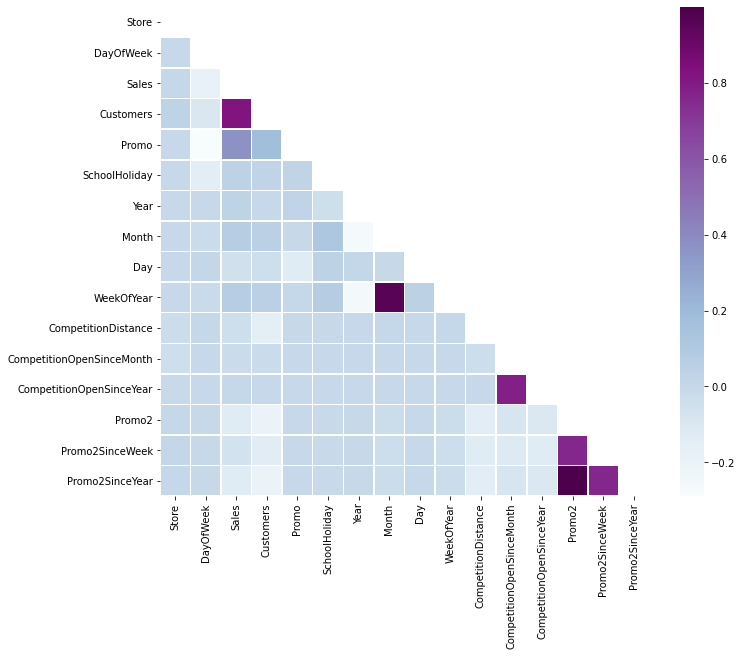

In [21]:
#correlation 
#exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

**Comments:** 

* We have the strong positive correlations between Sales with Customers and Promo.

* Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

**Time Series Analysis and Forecasting with Prophet**

In [22]:
df[df.Store==75].loc[:]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
74,75,5,2015-07-31,7444,807,1,1,0,1
1189,75,4,2015-07-30,7551,711,1,1,0,1
2304,75,3,2015-07-29,7476,664,1,1,0,1
3419,75,2,2015-07-28,6292,629,1,1,0,1
4534,75,1,2015-07-27,7346,754,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1009479,75,1,2013-01-07,6898,753,1,1,0,0
1011709,75,6,2013-01-05,5464,622,1,0,0,0
1012824,75,5,2013-01-04,5882,648,1,0,0,1
1013939,75,4,2013-01-03,5290,596,1,0,0,1


In [5]:
# importing data
df = pd.read_csv("/Users/thientrangbui/Dropbox/Kaggle competion/rossmann-store-sales/data rossmann-store-sales/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]


In [20]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [23]:
# sales for the store number 1 (StoreType B), just take an example 
sales = df[df.Store == 75].loc[:, ['Date', 'Sales']]

In [24]:
# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [25]:
#rename the columns before using the Prophet 
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1015054,2013-01-02,5844
1013939,2013-01-03,5290
1012824,2013-01-04,5882
1011709,2013-01-05,5464
1009479,2013-01-07,6898


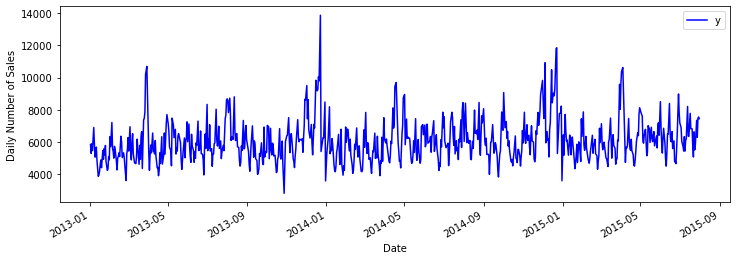

In [26]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = "blue")
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

**Using Prophet for modeling Holidays**

In [27]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [50]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 6*7
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
819,2015-09-05
820,2015-09-06
821,2015-09-07
822,2015-09-08
823,2015-09-09
824,2015-09-10
825,2015-09-11


In [51]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
819,2015-09-05,5952.796726,3939.723334,8003.093364
820,2015-09-06,5985.771390,3928.792800,8005.846537
821,2015-09-07,6535.730250,4616.607406,8610.180115
822,2015-09-08,5519.352593,3444.370387,7586.773184
823,2015-09-09,5390.762077,3293.484605,7289.110407
824,2015-09-10,5608.644375,3505.491440,7553.573382
825,2015-09-11,6125.723852,4140.389198,8020.569804


In [52]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

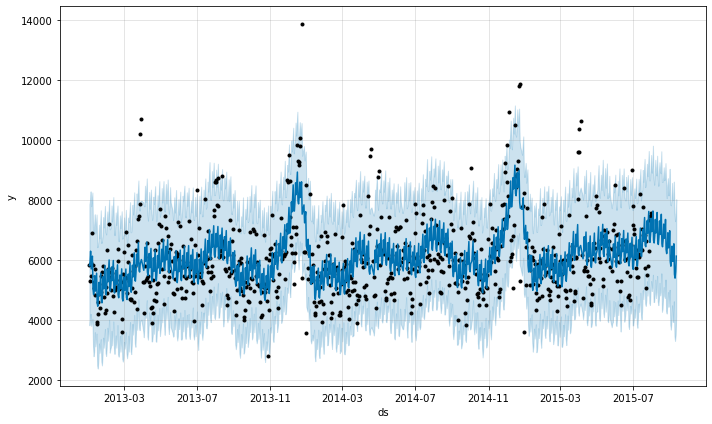

In [53]:
# visualizing predicions
my_model.plot(forecast);

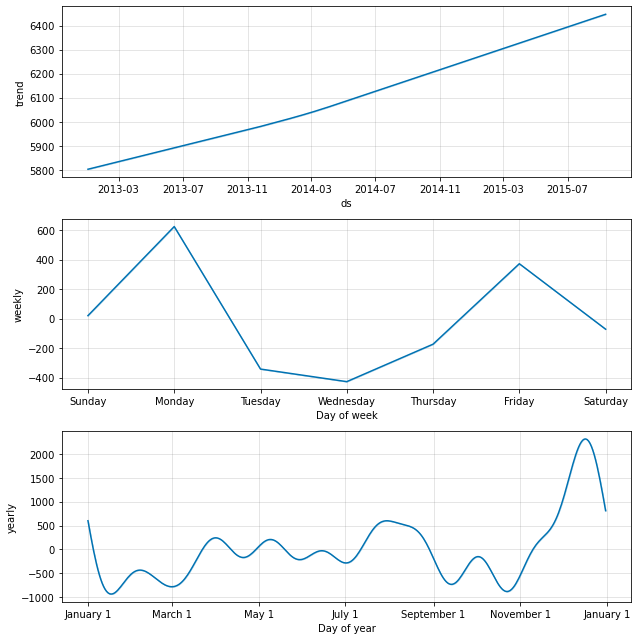

In [54]:
my_model.plot_components(forecast);

In [33]:
df.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

**Note:**

We can try for any store we want to se